<a href="https://colab.research.google.com/github/nbPittigiani/airline_passenger_satisfaction/blob/main/airline_passenger_satisfaction_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Airline Passenger Satisfaction**

[Airline Passenger Satisfaction](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction)

## **Notebook Scope: Tackling the Curse of Dimensionality**

This notebook applies **Unsupervised Machine Learning** techniques to explore the structure of the data. The primary challenge is the high number of correlated variables. When variables are highly correlated, they carry redundant information.

**The PCA Approach:**
PCA creates new factors based on linear combinations of the original variables. These factors are designed to be:

1.
**Orthogonal:** Completely uncorrelated with each other.


2.
**Efficient:** The first few factors explain the maximum amount of variance (information) in the dataset.



By applying PCA, we move from a high-dimensional space (many specific questions) to a lower-dimensional space (fewer latent factors), allowing for a **structural reduction** of the database while retaining the essential information.

### **1. Business Problem & Context**

In the highly competitive airline industry, understanding customer satisfaction is crucial for maintaining loyalty and brand reputation. While passengers provide ratings on numerous specific aspects of their journey—from *Leg room service* to *Gate location*—analyzing these variables individually can be overwhelming and redundant due to high correlations between them.

The core business problem is not just predicting satisfaction, but understanding its **structural composition**. We aim to identify **latent constructs** (unobservable factors) that drive the passenger experience. For instance, do passengers perceive "Check-in service" and "Gate location" as separate issues, or do they mentally group them into a single "Ground Service" experience?

By applying **Principal Component Analysis (PCA)**, we aim to:

* Reduce the dimensionality of the satisfaction survey.
* Extract orthogonal (uncorrelated) factors that summarize the original variables.


* Simplify the decision-making process for stakeholders by focusing on key performance dimensions rather than 23 individual metrics.

In [208]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'airline-passenger-satisfaction' dataset.
Path to dataset files: /kaggle/input/airline-passenger-satisfaction


### **2. Dataset Overview**

The dataset consists of an airline passenger satisfaction survey. It includes passenger metadata, specific feedback ratings (scale **1-5**, with **0** indicating 'Not Applicable'), and the final satisfaction outcome categorized as **'neutral or dissatisfied'** or **'satisfied'**.


**Focus for Analysis:**
We will focus on extracting latent factors from the **input variables** (metrics and survey responses) that drive the passenger experience.

**Selected Variables for Analysis:**

* **1. Input Variables (Features for PCA):**
  * **Operational Metrics:** *Age, Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes.*
  * **Survey Feedback Ratings (1-5):** *Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Check-in service, Inflight service, Cleanliness.*
* **Transformed Categorical (Inputs):**
  * *Class* (Ordinal Encoded: Eco=1, Eco Plus=2, Business=3)
  * *Type of Travel* (Binary Encoded: Personal=0, Business=1)
  * *Customer Type* (Binary Encoded: Disloyal=0, Loyal=1)


* **2. Target Variable (Outcome - Excluded from PCA Calculation):**
  * **Satisfaction:** This is the binary classification target labeled as **"neutral or dissatisfied"** vs **"satisfied"**.
  * *Note: This variable will be encoded (0/1) and used only **after** the PCA to validate if the extracted factors can visually or statistically separate these two groups of passengers.*


* **Excluded Variables:**
  * *Gender* (Excluded due to low structural contribution).

In [209]:
#!pip install factor_analyzer -q

In [239]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from typing import List, Tuple, Optional, Union, Any
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

In [211]:
def load_first_csv_from_directory(directory_path: str) -> Optional[pd.DataFrame]:
    """
    Scans a directory for the first CSV file and loads it into a pandas DataFrame.
    """

    # 1. Verify if directory exists to avoid FileNotFoundError
    if not os.path.exists(directory_path):
        print(f"Error: Directory '{directory_path}' does not exist.")
        return None

    # 2. List all files in the specified path
    files_in_path = os.listdir(directory_path)

    # 3. Find the first file ending with .csv using a generator
    csv_file_name = next((f for f in files_in_path if f.endswith('.csv')), None)

    if csv_file_name:
        # 4. Construct full path and load data
        full_csv_path = os.path.join(directory_path, csv_file_name)
        df = pd.read_csv(full_csv_path)
        print(f"Successfully loaded '{csv_file_name}' into df.")
        return df
    else:
        # Handle case where no CSV is present
        print(f"No CSV file found in the directory: {directory_path}")
        return None

In [212]:
df = load_first_csv_from_directory(path)

Successfully loaded 'train.csv' into df.


In [213]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [214]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [215]:
df.isnull().sum()

,0
Unnamed: 0,0
id,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0


In [216]:
def drop_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows with missing values in a specific column and reports the loss.
    """
    # 1. Capture initial shape for reporting
    initial_rows = df.shape[0]

    # 2. Drop rows where the target column is NaN
    # Use copy() to ensure we return a new DataFrame and avoid SettingWithCopyWarning
    df_cleaned = df.dropna().copy()

    # 3. Calculate and print statistics
    dropped_rows = initial_rows - df_cleaned.shape[0]
    percent_lost = (dropped_rows / initial_rows) * 100

    print(f"Dropped {dropped_rows} rows ({percent_lost:.2f}% of data).")
    print(f"New dataset shape: {df_cleaned.shape}")

    return df_cleaned

In [217]:
df.duplicated(subset='id').sum()

np.int64(0)

In [218]:
df = drop_missing_values(df)

Dropped 310 rows (0.30% of data).
New dataset shape: (103594, 25)


In [219]:
df = df.drop(['id','Unnamed: 0'], axis=1).reset_index(drop=True)
df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103589,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103590,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103591,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103592,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


We fill 310 rows containing missing values in Arrival Delay in Minutes ($0.30\%$ of the dataset). This listwise deletion was preferred over imputation to ensure a valid input matrix for PCA while preserving the authentic correlation structure and variance of the original data.

In [220]:
cat_vars = df.select_dtypes(include=['object']).columns

for col in cat_vars:
    print(f"{col}: {df[col].unique()}")

Gender: ['Male' 'Female']
Customer Type: ['Loyal Customer' 'disloyal Customer']
Type of Travel: ['Personal Travel' 'Business travel']
Class: ['Eco Plus' 'Business' 'Eco']
satisfaction: ['neutral or dissatisfied' 'satisfied']


In [221]:
def prepare_airline_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Selects specific features for PCA and encodes categorical variables
    using exact string matching from the dataset unique values.

    Returns:
        X_pca (pd.DataFrame): The numerical features ready for scaling/PCA.
        y_target (pd.Series): The encoded target variable for validation.
    """

    # 1. Define Variable Lists
    # Metric variables (Continuous + Survey Ratings 1-5)
    metric_features = [
        'Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
        'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
        'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
        'Inflight entertainment', 'On-board service', 'Leg room service',
        'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness'
    ]

    # Categorical variables to be encoded for PCA input (Gender excluded as per scope)
    categorical_features = ['Class', 'Type of Travel', 'Customer Type']

    # Target variable
    target_col = 'satisfaction'

    # 2. Define Mappings (Encoding)
    # Ordinal Encoding for Class (Eco=1 < Eco Plus=2 < Business=3)
    class_map = {
        'Eco': 1,
        'Eco Plus': 2,
        'Business': 3
    }

    # Binary Encoding for Travel (Personal=0, Business=1)
    travel_map = {
        'Personal Travel': 0,
        'Business travel': 1
    }

    # Binary Encoding for Customer Type (Disloyal=0, Loyal=1)
    cust_map = {
        'disloyal Customer': 0,
        'Loyal Customer': 1
    }

    # Binary Encoding for Target (Neutral/Dissatisfied=0, Satisfied=1)
    satisfaction_map = {
        'neutral or dissatisfied': 0,
        'satisfied': 1
    }

    # 3. Apply Transformations
    df_encoded = df.copy()

    # Apply maps safely
    df_encoded['Class'] = df_encoded['Class'].map(class_map)
    df_encoded['Type of Travel'] = df_encoded['Type of Travel'].map(travel_map)
    df_encoded['Customer Type'] = df_encoded['Customer Type'].map(cust_map)
    df_encoded['satisfaction'] = df_encoded['satisfaction'].map(satisfaction_map)

    # 4. Assemble Final Dataframes
    # Combine metrics + encoded categoricals for X
    X_pca = df_encoded[metric_features + categorical_features].copy()
    y_target = df_encoded[target_col].copy()

    # Validation print
    print(f"Features prepared successfully.")
    print(f"X shape: {X_pca.shape}")
    print(f"Class distribution preview: {df_encoded['Class'].value_counts().to_dict()}")
    print(f"Travel distribution preview: {df_encoded['Type of Travel'].value_counts().to_dict()}")
    print(f"Customer Type distribution preview: {df_encoded['Customer Type'].value_counts().to_dict()}")
    print(f"Target distribution preview: {df_encoded['satisfaction'].value_counts().to_dict()}")

    return X_pca, y_target

In [222]:
X, y = prepare_airline_features(df)

Features prepared successfully.
X shape: (103594, 21)
Class distribution preview: {3: 49533, 1: 46593, 2: 7468}
Travel distribution preview: {1: 71465, 0: 32129}
Customer Type distribution preview: {1: 84662, 0: 18932}
Target distribution preview: {0: 58697, 1: 44897}


In [223]:
X

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Class,Type of Travel,Customer Type
0,13,460,25,18.0,3,4,3,1,5,3,...,5,4,3,4,4,5,5,2,0,1
1,25,235,1,6.0,3,2,3,3,1,3,...,1,1,5,3,1,4,1,3,1,0
2,26,1142,0,0.0,2,2,2,2,5,5,...,5,4,3,4,4,4,5,3,1,1
3,25,562,11,9.0,2,5,5,5,2,2,...,2,2,5,3,1,4,2,3,1,1
4,61,214,0,0.0,3,3,3,3,4,5,...,3,3,4,4,3,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103589,23,192,3,0.0,2,1,2,3,2,2,...,2,3,1,4,2,3,2,1,1,0
103590,49,2347,0,0.0,4,4,4,4,2,4,...,5,5,5,5,5,5,4,3,1,1
103591,30,1995,7,14.0,1,1,1,3,4,1,...,4,3,2,4,5,5,4,3,1,0
103592,22,1000,0,0.0,1,1,1,5,1,1,...,1,4,5,1,5,4,1,1,1,0


In [224]:
y

,satisfaction
0,0
1,0
2,1
3,0
4,1
...,...
103589,0
103590,1
103591,0
103592,0


### **3. Proposed Workflow**

The analysis will follow a rigorous statistical workflow to ensure the suitability and quality of the factor extraction:

1. **Data Preparation:**
    * Standardization (Z-Score).



2. **Adequacy Tests (Pre-PCA):**
    * **Correlation Matrix:** We will generate the Pearson correlation matrix to inspect relationships. We look for values close to -1 or +1, which justify the creation of factors.


    * **Bartlett's Test of Sphericity:** We will test the null hypothesis  that the correlation matrix is equal to the identity matrix. We need to reject  to prove that the variables are correlated and PCA is suitable.


3. **Factor Extraction:**
    * **Eigenvalues & Eigenvectors:** We will calculate eigenvalues to determine the variance explained by each factor.


    *  **Kaiser Criterion:** We will select the number of factors to retain based on the "Latent Root Criterion," keeping only factors with **Eigenvalues > 1**.



4. **Analysis & Interpretation:**
    * **Factor Loadings:** We will analyze the correlations between the original variables and the extracted factors to interpret what each factor represents (e.g., "Comfort", "Logistics").


    * **Communalities:** We will assess how much variance of each original variable is retained in the final model.

In [225]:
def analyze_correlations_clustermap(X_input: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes the data (Z-Score) and plots a Hierarchical Clustermap
    of the Pearson Correlation Matrix.

    Args:
        X_input (pd.DataFrame): The raw feature matrix.

    Returns:
        X_std (pd.DataFrame): The standardized data (Z-scores) for next steps.
    """

    # 1. Standardization (Z-Score)
    # Essential for PCA and correct correlation magnitude
    scaler = StandardScaler()
    X_values = scaler.fit_transform(X_input)
    X_std = pd.DataFrame(X_values, columns=X_input.columns)

    print("Data successfully standardized (Mean ~ 0, Std ~ 1).")

    # 2. Correlation Matrix Calculation
    corr_matrix = X_std.corr(method='pearson')

    # 3. Visualization (Clustermap)
    # The clustermap reorders rows and cols to show clusters of correlated vars
    g = sns.clustermap(
        corr_matrix,
        method='ward',      # Ward's linkage is generally effective for clusters
        cmap='RdBu_r',      # Red-White-Blue diverging colormap
        center=0,           # Center color at 0
        vmin=-1, vmax=1,    # Pearson limits
        annot=True,         # Show numbers (can be helpful if figure is large enough)
        fmt=".2f",          # 2 decimal places
        figsize=(20, 20),   # Large size to read labels
        linewidths=.5,
        dendrogram_ratio=(.1, .1), # Control size of dendrogram trees
        cbar_pos=(0.02, 0.8, 0.03, 0.15) # Position colorbar
    )

    plt.title('Hierarchical Clustermap of Correlations', fontsize=18, y=1.2)
    plt.show()

    return X_std

Data successfully standardized (Mean ~ 0, Std ~ 1).


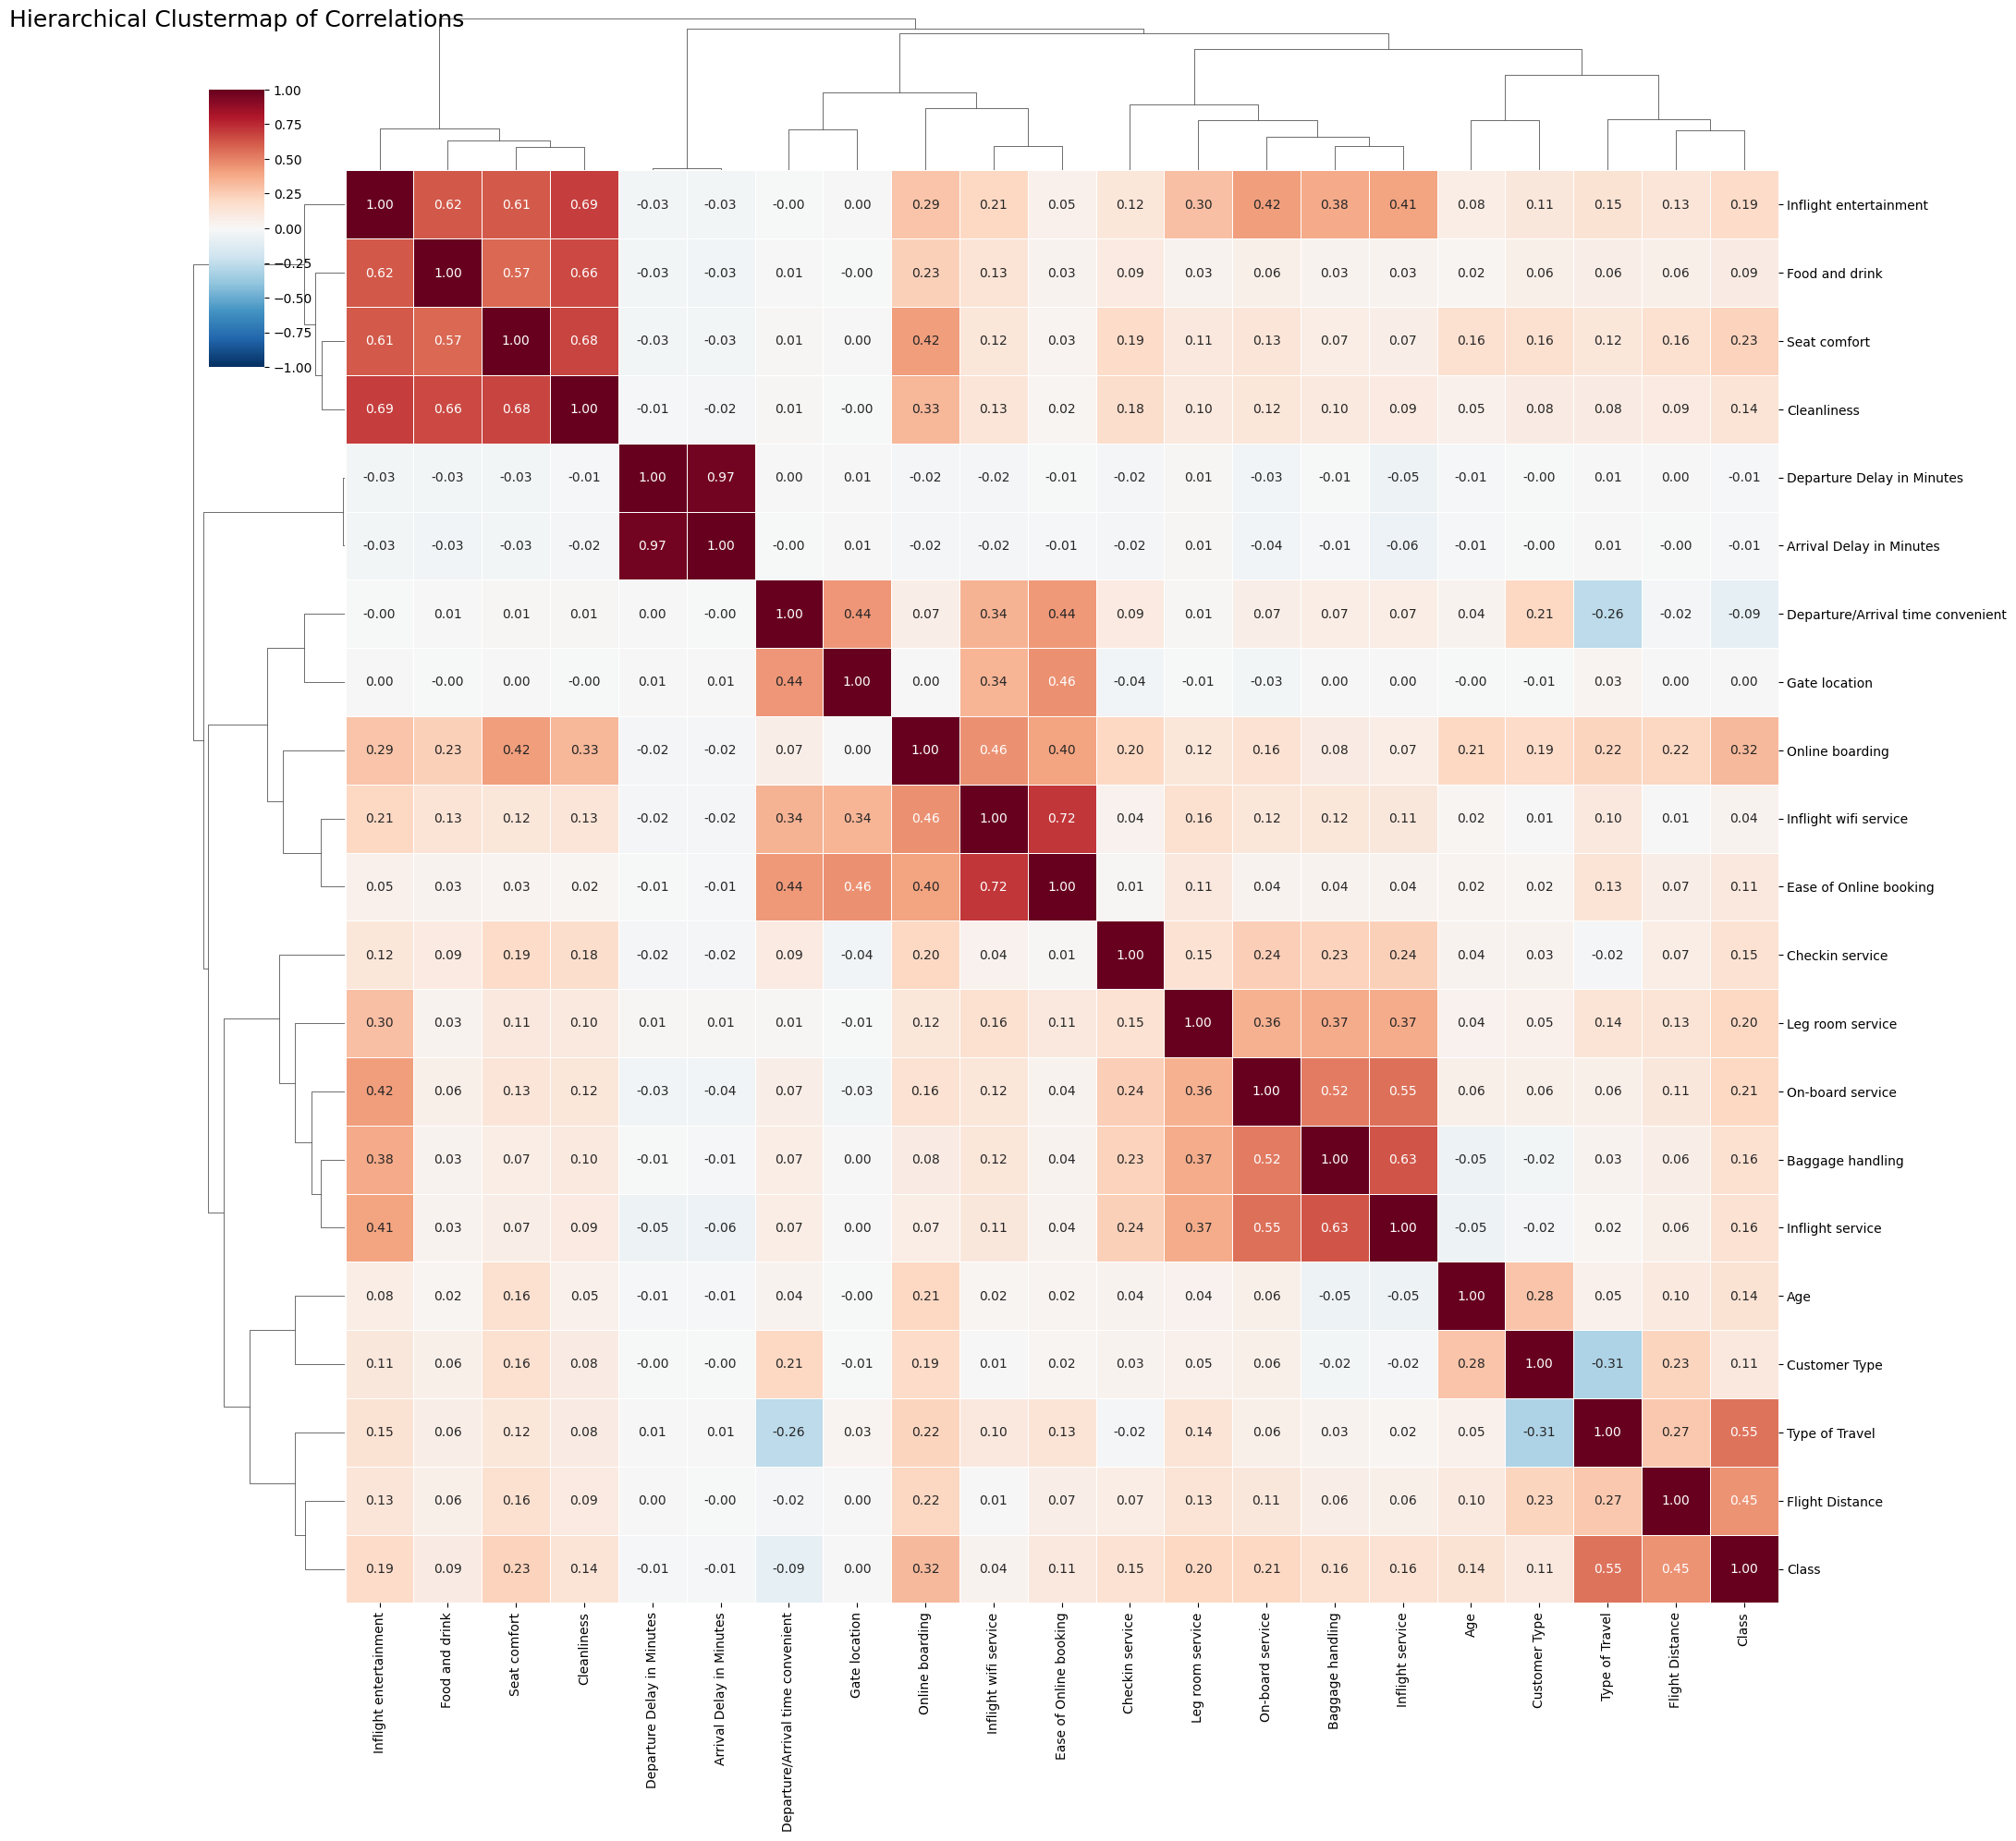

In [226]:
X_std = analyze_correlations_clustermap(X)

In [227]:
def run_bartlett_test(X_std: pd.DataFrame) -> Tuple[float, float]:
    """
    Performs Bartlett's Test of Sphericity to check if the dataset is suitable for PCA.

    Args:
        X_std (pd.DataFrame): The standardized feature matrix.

    Returns:
        chi_square_value (float): The test statistic.
        p_value (float): The significance level (aiming for < 0.05).
    """

    print("--- Bartlett's Test of Sphericity ---")

    # 1. Calculate Bartlett's Sphericity
    # Pass the dataframe directly; the library handles the correlation calculation internally
    chi_square_value, p_value = calculate_bartlett_sphericity(X_std)

    # 2. Output results
    print(f"Chi-square value: {chi_square_value:.4f}")
    print(f"P-value: {p_value:.4e}")

    # 3. Interpretation
    if p_value < 0.05:
        print("Result: REJECT H0. The variables are correlated.")
        print("Conclusion: PCA/Factor Analysis is SUITABLE for this dataset.")
    else:
        print("Result: FAIL to reject H0. The variables are likely uncorrelated.")
        print("Conclusion: PCA may NOT be suitable.")

    return chi_square_value, p_value

In [228]:
chi, p = run_bartlett_test(X_std)

--- Bartlett's Test of Sphericity ---
Chi-square value: 1038332.4003
P-value: 0.0000e+00
Result: REJECT H0. The variables are correlated.
Conclusion: PCA/Factor Analysis is SUITABLE for this dataset.


In [229]:
def extract_factors_analyzer(X_std: pd.DataFrame) -> Tuple[FactorAnalyzer, int, pd.DataFrame]:
    """
    Performs Factor Analysis (PCA method) and returns a detailed summary
    including Eigenvalues, Variance %, and Cumulative Variance %.

    Args:
        X_std (pd.DataFrame): The standardized feature matrix.

    Returns:
        fa_model (FactorAnalyzer): The fitted model object.
        n_factors (int): Number of factors to retain (Kaiser Criterion > 1).
        eigen_df (pd.DataFrame): Detailed summary table.
    """

    # 1. Initialize and Fit Model
    # We fit n_factors = number of features to see the complete variance distribution
    n_features = X_std.shape[1]
    fa = FactorAnalyzer(n_factors=n_features, rotation=None, method='principal').fit(X_std)

    # 2. Get Variance Metrics
    # get_factor_variance() returns 3 arrays:
    # [0] SS Loadings (Eigenvalues in unrotated PCA)
    # [1] Proportional Variance (Variance %)
    # [2] Cumulative Variance
    ev, var_ratio, cum_var = fa.get_factor_variance()

    # 3. Create Summary DataFrame
    factor_indices = [f"Factor {i+1}" for i in range(n_features)]

    eigen_df = pd.DataFrame({
        'Eigenvalue': ev,
        'Variance Explained': var_ratio,
        'Cumulative Variance': cum_var
    }, index=factor_indices)

    # 4. Apply Kaiser Criterion (Eigenvalue > 1)
    # Filter factors where Eigenvalue > 1
    n_factors = sum(eigen_df['Eigenvalue'] > 1)

    # Select only the retained factors for the summary print
    retained_df = eigen_df.head(n_factors)
    total_var_explained = retained_df['Variance Explained'].sum()

    print("--- Factor Extraction Summary (Method: Principal Component) ---")
    print(f"Factors Retained (Eigenvalue > 1): {n_factors}")
    print(f"Total Variance Explained by Retained Factors: {total_var_explained:.2%}")

    print("\nDetailed Table (Top Factors):")
    # Show n_factors + 1 to see the "cutoff point" clearly
    eigen_df.head(n_factors + 1)

    # 5. Scree Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_features + 1), ev, marker='o', linestyle='-', color='b', label='Eigenvalues')
    plt.axhline(y=1, color='r', linestyle='--', label='Kaiser Criterion (Ev=1)')

    plt.title('Scree Plot', fontsize=14)
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return fa, n_factors, eigen_df

--- Factor Extraction Summary (Method: Principal Component) ---
Factors Retained (Eigenvalue > 1): 6
Total Variance Explained by Retained Factors: 66.44%

Detailed Table (Top Factors):


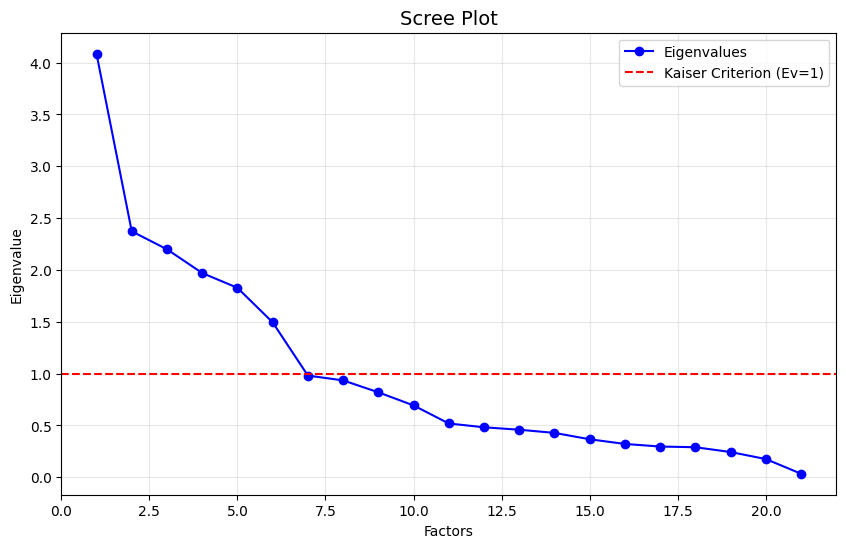

In [230]:
fa_model, n_comps, stats_df = extract_factors_analyzer(X_std)

In [231]:
stats_df

,Eigenvalue,Variance Explained,Cumulative Variance
Factor 1,4.086098,0.194576,0.194576
Factor 2,2.373068,0.113003,0.307579
Factor 3,2.199515,0.104739,0.412318
Factor 4,1.970532,0.093835,0.506153
Factor 5,1.827889,0.087042,0.593195
Factor 6,1.494933,0.071187,0.664383
Factor 7,0.981247,0.046726,0.711109
Factor 8,0.934917,0.044520,0.755629
Factor 9,0.819931,0.039044,0.794673
Factor 10,0.693357,0.033017,0.827690


In [232]:
def analyze_factor_loadings(
    X_std: pd.DataFrame,
    n_factors: int
) -> pd.DataFrame:
    """
    Fits the Factor Analysis model with the selected number of factors
    and applies Varimax rotation to interpret the Factor Loadings.

    Args:
        X_std (pd.DataFrame): The standardized feature matrix.
        n_factors (int): The optimal number of factors determined by Kaiser Criterion.

    Returns:
        loadings_df (pd.DataFrame): Matrix showing correlation between vars and factors.
    """

    # 1. Fit Model with Selected Factors & Rotation
    # method='principal': Aligns with the PCA mathematical approach
    # rotation='varimax': Orthogonal rotation to maximize high/low loadings for easier interpretation
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='principal').fit(X_std)

    # 2. Extract Loadings
    loadings = fa.loadings_

    # Create a DataFrame for better visualization
    # Naming columns Factor 1, Factor 2, etc.
    factor_cols = [f"Factor {i+1}" for i in range(n_factors)]
    loadings_df = pd.DataFrame(loadings, columns=factor_cols, index=X_std.columns)

    # 3. Visualization (Heatmap)
    plt.figure(figsize=(14, 12))

    # Plot heatmap
    sns.heatmap(
        loadings_df,
        cmap='RdBu_r',      # Red-Blue diverging colormap
        center=0,
        vmax=1, vmin=-1,
        annot=True,         # Show correlation values
        fmt=".2f",          # 2 decimal places
        linewidths=.5
    )

    plt.title(f'Factor Loadings Matrix (Varimax Rotation) - {n_factors} Factors', fontsize=16)
    plt.ylabel('Original Variables')
    plt.xlabel('Latent Factors')
    plt.tight_layout()
    plt.show()

    return fa, loadings_df

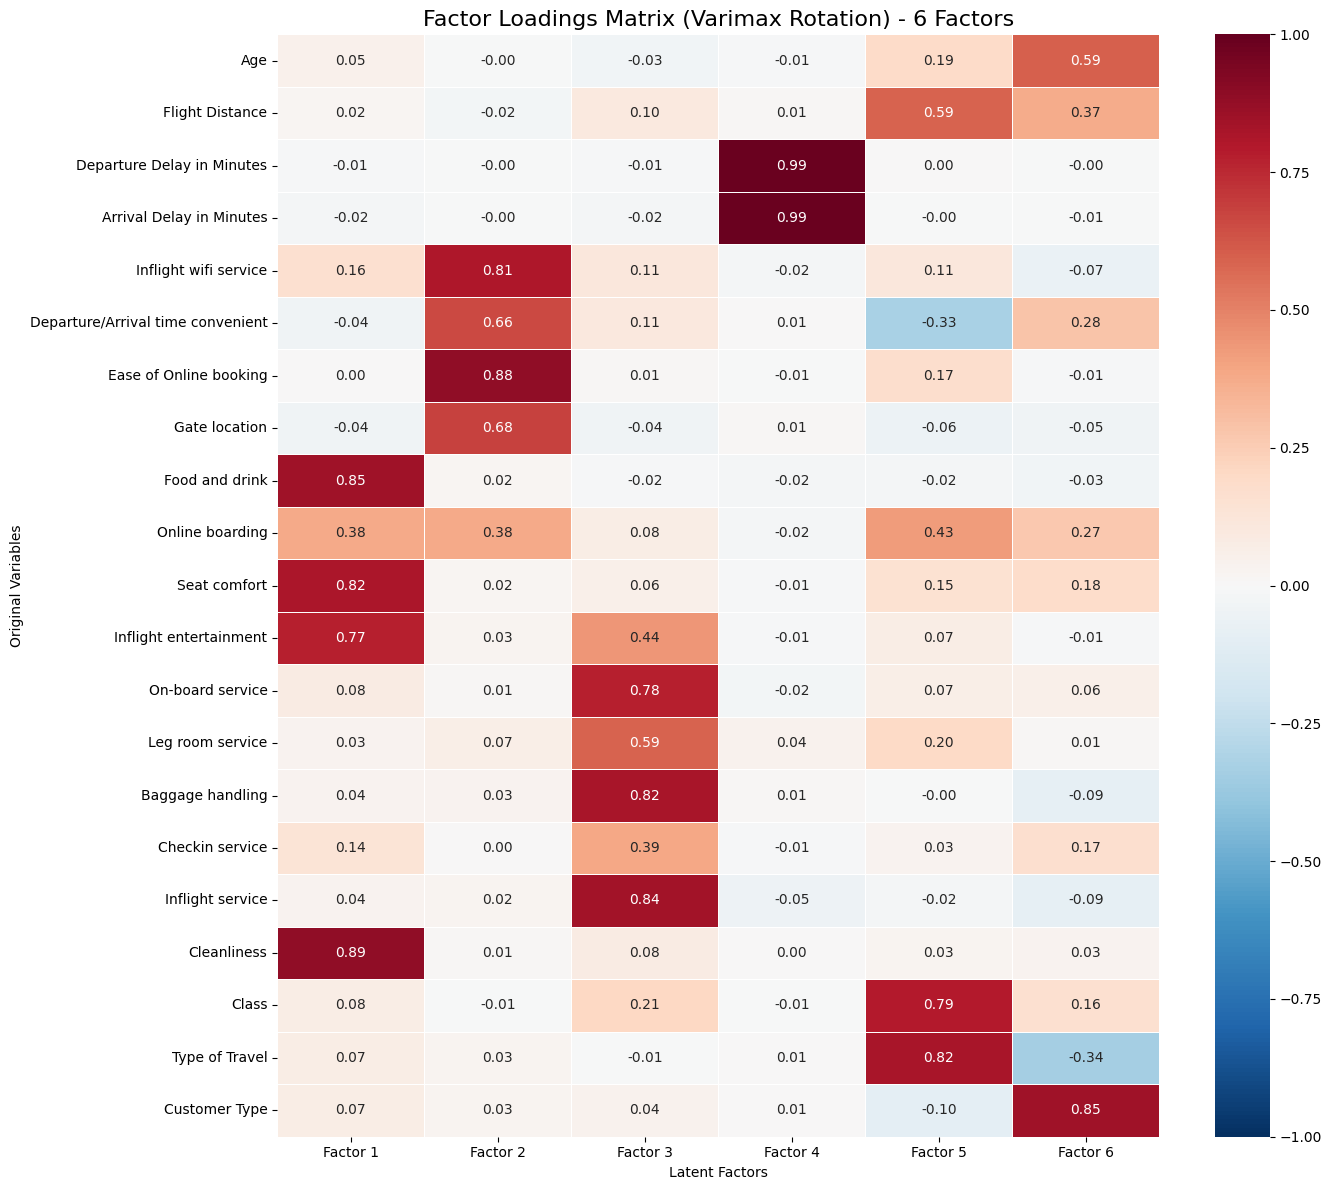

In [233]:
fa_model, loadings_matrix = analyze_factor_loadings(X_std, n_factors=6)

In [234]:
loadings_matrix

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
Age,0.052122,-0.000487,-0.034348,-0.012842,0.187579,0.594170
Flight Distance,0.019876,-0.023970,0.100793,0.008393,0.587106,0.369840
Departure Delay in Minutes,-0.014663,-0.001692,-0.014634,0.990620,0.001825,-0.004470
Arrival Delay in Minutes,-0.016556,-0.003048,-0.018975,0.990559,-0.000914,-0.006718
Inflight wifi service,0.163104,0.811744,0.109848,-0.016010,0.109564,-0.067298
Departure/Arrival time convenient,-0.042839,0.659479,0.107243,0.007793,-0.326886,0.281974
Ease of Online booking,0.002941,0.883491,0.012738,-0.006599,0.174573,-0.012061
Gate location,-0.044673,0.681115,-0.040636,0.010804,-0.059606,-0.046307
Food and drink,0.851356,0.022181,-0.015017,-0.018837,-0.017204,-0.032694
Online boarding,0.380016,0.377061,0.077034,-0.018059,0.426982,0.268054


**Factor Interpretation (Business Labels)**

Based on the Rotated Factor Matrix (Varimax), we identified 6 latent constructs that drive passenger satisfaction. The table below maps the original variables to their corresponding factors:

| Factor | Key Variables (High Loadings) | Business Interpretation (Label) |
| :--- | :--- | :--- |
| **Factor 1** | Food and drink (0.85), Cleanliness (0.89), Seat comfort (0.82), Inflight entertainment (0.77) | **In-flight Experience & Comfort**<br>Reflects the tangible quality of the cabin and amenities. |
| **Factor 2** | Ease of Online booking (0.88), Inflight wifi (0.81), Gate location (0.68), Time convenient (0.66) | **Digital Convenience & Logistics**<br>Focuses on ease of access, scheduling, and connectivity. |
| **Factor 3** | Inflight service (0.84), Baggage handling (0.82), On-board service (0.78), Leg room (0.59) | **Crew Service & Operations**<br>Reflects human interaction/service and operational handling. |
| **Factor 4** | Departure Delay (0.99), Arrival Delay (0.99) | **Flight Delays**<br>A purely technical factor capturing punctuality. |
| **Factor 5** | Type of Travel (0.82), Class (0.79), Flight Distance (0.59) | **Premium/Business Profile**<br>Distinguishes corporate/long-haul/high-class travel from personal/short-haul. |
| **Factor 6** | Customer Type (0.85), Age (0.59) | **Loyalty & Demographics**<br>Captures the customer's loyalty status and maturity. |

In [250]:
def calculate_and_save_scores(
    fa_model: FactorAnalyzer,
    X_std: pd.DataFrame,
    original_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Calculates Factor Scores for each observation and appends them
    to the original dataframe with descriptive business labels.

    Args:
        fa_model (FactorAnalyzer): The fitted Factor Analysis model.
        X_std (pd.DataFrame): The standardized feature matrix used for fitting.
        original_df (pd.DataFrame): The original cleaned dataframe (with target).

    Returns:
        df_final (pd.DataFrame): The original dataframe plus the 6 new Score columns.
    """

    # 1. Calculate Factor Scores
    # The transform method applies the weights (scores matrix) to the data
    # resulting in the coordinates of each passenger in the factor space.
    scores = fa_model.transform(X_std)

    # 2. Define Business Labels for Columns
    # Based on our previous interpretation step
    score_columns = [
        'Score_Experience_Comfort',   # Factor 1
        'Score_Digital_Logistics',    # Factor 2
        'Score_Service_Operations',   # Factor 3
        'Score_Delays',               # Factor 4
        'Score_Premium_Profile',      # Factor 5
        'Score_Loyalty_Demographics'  # Factor 6
    ]

    # 3. Create DataFrame and Merge
    scores_df = pd.DataFrame(scores, columns=score_columns, index=X_std.index)

    # Concatenate along columns (axis=1)
    # Using index alignment to ensure data integrity
    df_final = pd.concat([original_df, scores_df], axis=1)

    print("Factor Scores successfully calculated and added.")
    print(f"New Dataset Shape: {df_final.shape}")

    return df_final, score_columns

In [251]:
df_complete, score_columns = calculate_and_save_scores(fa_model, X_std, df)

Factor Scores successfully calculated and added.
New Dataset Shape: (103594, 29)


In [237]:
df_complete

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Score_Experience_Comfort,Score_Digital_Logistics,Score_Service_Operations,Score_Delays,Score_Premium_Profile,Score_Loyalty_Demographics
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,25,18.0,neutral or dissatisfied,1.532425,-0.266395,0.766840,0.181675,-1.429456,-0.226779
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,6.0,neutral or dissatisfied,-1.961329,0.252092,-0.549492,-0.333296,1.047859,-2.032960
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,0,0.0,satisfied,1.557642,-0.759134,0.260152,-0.380587,0.591530,-0.127717
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,11,9.0,neutral or dissatisfied,-1.418192,1.240171,-0.303467,-0.102644,0.326913,-0.452792
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,0,0.0,satisfied,0.426496,0.241257,-0.323668,-0.387168,0.762574,0.646514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103589,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,...,2,3,0.0,neutral or dissatisfied,-0.883748,-0.576310,-0.728933,-0.419934,-0.192171,-2.298193
103590,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,...,4,0,0.0,satisfied,0.129331,0.856252,1.623410,-0.343451,0.941016,0.740711
103591,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,...,4,7,14.0,neutral or dissatisfied,0.693348,-1.532132,0.301958,-0.150754,0.609958,-1.526843
103592,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,...,1,0,0.0,neutral or dissatisfied,-2.007873,-0.734738,0.010044,-0.426142,0.108167,-1.775209


In [248]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    1035

In [238]:
df_complete.isnull().sum()

,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0
Ease of Online booking,0
Gate location,0


In [245]:
def analyze_communalities(fa_model: Any, feature_names: Union[List[str], pd.Index]) -> pd.DataFrame:
    """
    Calculates and visualizes the communalities of the variables from a Factor Analysis model.

    Parameters:
    -----------
    fa_model : Any
        The fitted FactorAnalyzer model instance.
    feature_names : Union[List[str], pd.Index]
        List or Index containing the names of the features corresponding to the model data.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing the sorted communality values for each feature.
    """
    # 1. Extract Communalities
    comm = fa_model.get_communalities()

    # 2. Create a DataFrame
    df_comm = pd.DataFrame(
        comm,
        index=feature_names,
        columns=['Communality']
    ).sort_values(by='Communality', ascending=False)

    # 3. Plot a bargraph
    plt.figure(figsize=(12, 6))
    # Add a visual cutoff line at 0.5
    plt.axvline(x=0.5, color='r', linestyle='--', label='Communality Threshold')

    sns.barplot(
        x='Communality',
        y=df_comm.index,
        data=df_comm,
        palette='viridis',
    )

    plt.title('Communalities: Variance Explained by Extracted Factors', fontsize=16)
    plt.xlabel('Communality (0 to 1)')
    plt.ylabel('Original Variables')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Report variables with low communality
    low_comm_df = df_comm[df_comm['Communality'] < 0.5]

    if not low_comm_df.empty:
        print("\nWarning: The following variables have communality < 0.5:")
        print(f"\n{low_comm_df}")
    else:
        print("\n✅ All variables have communality greater than 0.5!")

    return df_comm

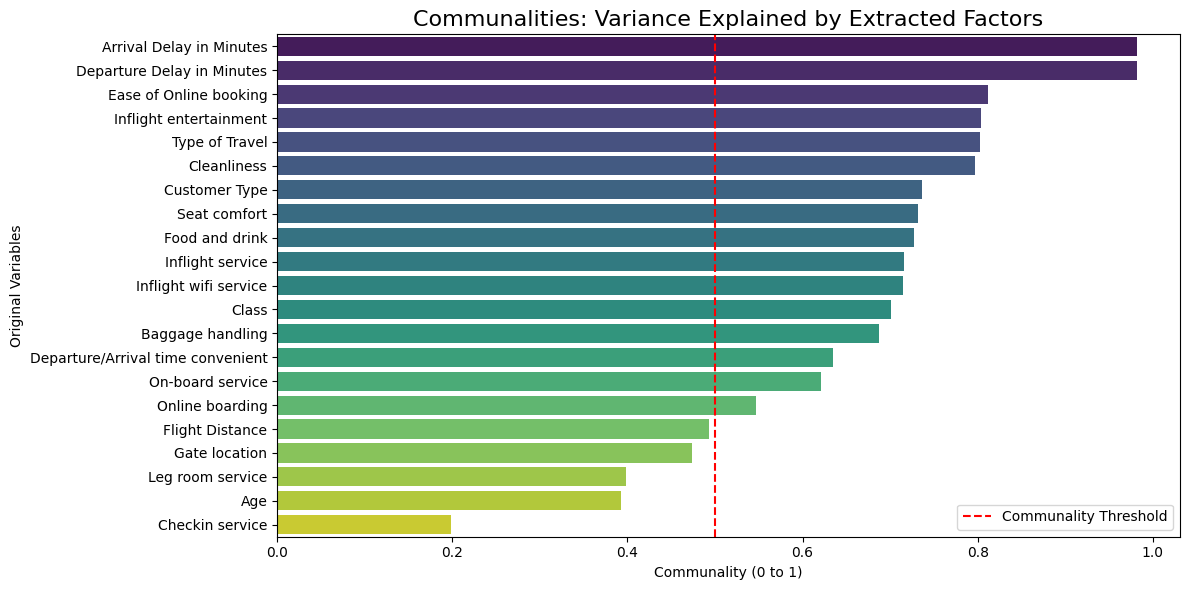



                  Communality
Flight Distance      0.492674
Gate location        0.473379
Leg room service     0.398013
Age                  0.392285
Checkin service      0.198841


In [246]:
communalities_df = analyze_communalities(fa_model, X_std.columns)

### **4. Ranking**

In [256]:
def calculate_ranking_from_eigenvalues(
    df: pd.DataFrame,
    eigen_df: pd.DataFrame,
    score_cols: List[str],
    target_col: str = 'satisfaction'
) -> pd.DataFrame:
    """
    Calculates the Global Ranking using weights directly from the Eigenvalues DataFrame.

    It automatically slices the 'Variance Explained' from eigen_df to match
    the number of score columns provided.

    Parameters:
    -----------
    df : pd.DataFrame
        The main dataframe containing the factor scores and target variable.
    eigen_df : pd.DataFrame
        The summary dataframe returned by 'extract_factors_analyzer',
        containing a 'Variance Explained' column.
    score_cols : List[str]
        List of column names representing the factor scores in the main df.
        (e.g. ['Score_Experience_Comfort', 'Score_Digital_Logistics', ...])
    target_col : str
        The name of the categorical target column for validation.

    Returns:
    --------
    pd.DataFrame
        The original dataframe with the new 'Global_Ranking' column added.
    """

    # 1. Extract Weights (Variance Explained)
    # We take the top N weights corresponding to the N score columns we have.
    # This ensures dimension alignment (e.g., if we have 6 scores, we take top 6 variances).
    n_factors = len(score_cols)

    try:
        # .values converts it to a numpy array for the dot product
        weights = eigen_df['Variance Explained'].iloc[:n_factors].values
    except KeyError:
        raise KeyError("The eigen_df must contain a column named 'Variance Explained'.")

    print(f"--- Calculating Ranking for {n_factors} Factors ---")
    print(f"Weights applied (Variance %): {weights}")

    # 2. Calculate Global Ranking (Dot Product)
    # Formula: Ranking = Sum(Score_i * Weight_i)
    df['Global_Ranking'] = df[score_cols].dot(weights)

    # 3. Validation: Boxplot Analysis
    # We want to see if the Ranking discriminates well between satisfaction levels.
    plt.figure(figsize=(10, 6))

    sns.boxplot(
        x=target_col,
        y='Global_Ranking',
        data=df,
        palette='viridis',
        showmeans=True
    )

    plt.title('Validation: Global Ranking vs. Satisfaction', fontsize=16)
    plt.xlabel('Satisfaction Status', fontsize=12)
    plt.ylabel('Global Ranking (Weighted Score)', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 4. Descriptive Stats for Validation
    print(f"\n--- Statistics by {target_col} ---")
    print(df.groupby(target_col)['Global_Ranking'].describe())

    return df

--- Calculating Ranking for 6 Factors ---
Weights applied (Variance %): [0.19457611 0.11300325 0.10473882 0.09383487 0.08704234 0.0711873 ]


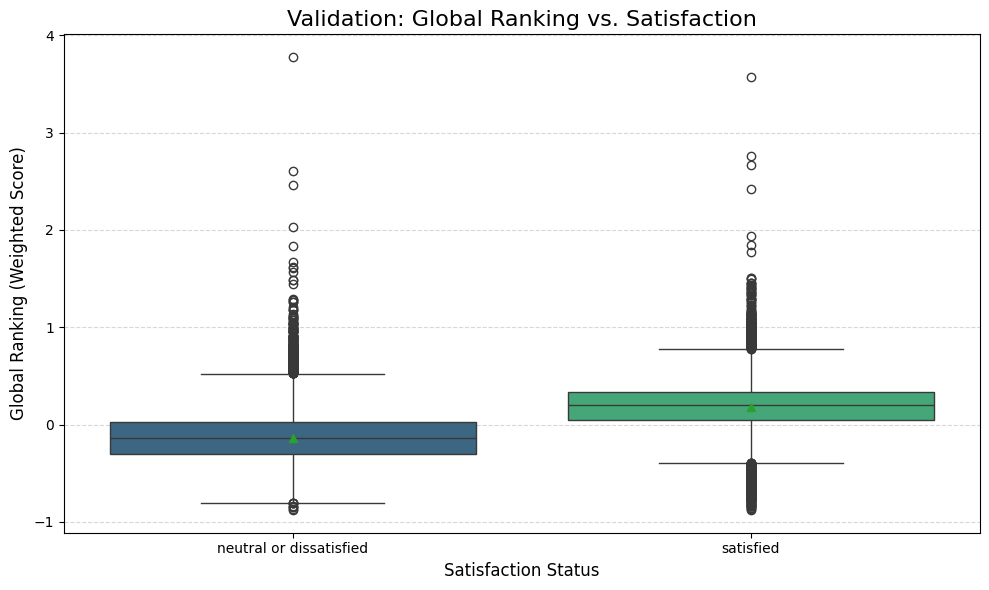


--- Statistics by satisfaction ---
                           count      mean       std       min       25%  \
satisfaction                                                               
neutral or dissatisfied  58697.0 -0.135369  0.241146 -0.872065 -0.303503   
satisfied                44897.0  0.176977  0.245608 -0.877853  0.043244   

                              50%       75%       max  
satisfaction                                           
neutral or dissatisfied -0.135057  0.028041  3.775691  
satisfied                0.199253  0.337908  3.569931  


In [257]:
df_final = calculate_ranking_from_eigenvalues(df_complete, stats_df, score_columns)

### **5. Conclusion: Global Ranking Validation**

The analysis of the **Global Ranking** yielded highly positive results, confirming the robustness of the Factor Analysis. The unsupervised ranking successfully discriminated between the target classes:

* **Satisfied** passengers exhibited consistently positive scores.
* **Neutral or Dissatisfied** passengers exhibited consistently negative scores.

This clear separation validates that the 6 extracted latent factors effectively capture the underlying structure of passenger satisfaction without prior knowledge of the target variable.


### **6. Next Steps:**
With the dimensionality reduction and feature engineering successfully validated on the training set, we will now proceed to the **Predictive Modeling** phase. The next objective is to apply these transformations to the **Test Dataset** to predict the `satisfaction` status (Satisfied vs. Neutral or Dissatisfied) using the engineered factors.